# Выбор локации для скважины

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Цель проекта

Необходимо **построить модель** для определения региона, где добыча принесёт наибольшую прибыль. Также нужно построить **95%-й доверительный интервал** и **риск убытков**. После оценки рисков нужно оставить лишь те **регионы**, в которых **вероятность убытков меньше 2.5%**. Среди них выбирают регион с наибольшей средней прибылью.

# Описание данных

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек 
* product 

В данной работе в качестве модели будем использовать линейную регрессию. В качестве baseline используем dummyRegressor.

## Загрузка и подготовка данных

Подключаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scipy.stats import shapiro, t, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind, t
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn import set_config
RANDOM_STATE = 42
TEST_SIZE = 0.25
BUDGET = 1*10**10
BARREL_PRICE = 450*1000
TOP_HOLE = 200
HOLE = 500

Загружаем данные:

In [2]:
try:
    reg_1 = pd.read_csv('geo_data_0.csv')
    reg_2 = pd.read_csv('geo_data_1.csv')
    reg_3 = pd.read_csv('geo_data_2.csv')

except:
    pass


Проверим датасеты на дубликаты по признаку id

Функция подсчета дубликатов

In [3]:
def search_duplicates(df):
    return df[["id"]].duplicated().sum()
    

In [4]:
data = [reg_1, reg_2, reg_3]

In [5]:
for i in enumerate(data):
    print(f'Дубликатов в {i[0]+1} датафрейме = {search_duplicates(i[1])}')

Дубликатов в 1 датафрейме = 10
Дубликатов в 2 датафрейме = 4
Дубликатов в 3 датафрейме = 4


Предположим, что дублированные данные - данные на одинаковых объектах, но собранные в разное время. Нас интересуют последние изменения:

In [6]:
reg_1 = reg_1.drop_duplicates(subset=['id'], keep='last')
reg_2 = reg_2.drop_duplicates(subset=['id'], keep='last')
reg_3 = reg_3.drop_duplicates(subset=['id'], keep='last')

Проверим данные на пропуски:

In [7]:
reg_1.isna().mean()

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

In [8]:
reg_2.isna().mean()

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

In [9]:
reg_3.isna().mean()

id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

# EDA

## Регион 1

Посмотрим описательные статистики для 1 региона:

In [10]:
reg_1[['f0', 'f1', 'f2']].describe()

,f0,f1,f2
count,99990.000000,99990.000000,99990.000000
mean,0.500412,0.250149,2.502656
std,0.871867,0.504434,3.248155
min,-1.408605,-0.848218,-12.088328
25%,-0.072683,-0.200877,0.287887
50%,0.502340,0.250252,2.516005
75%,1.073626,0.700654,4.714970
max,2.362331,1.343769,16.003790


Видим, что стандартное отклонение у величин небольшое, это говорит об отсутствии выбросов в данных. Чтобы в этом убедиться построим множественный scatterplot и построим на взаимосвязи в данных, а также их распределение.

Поскольку у нас 100к наблюдений, то я выберу подвыборку из 50к, чтобы снизить нагрузку на процессор. По закону ЦПТ распределение данной подвыборки будет близко к истинному распределению генеральной совокупности.

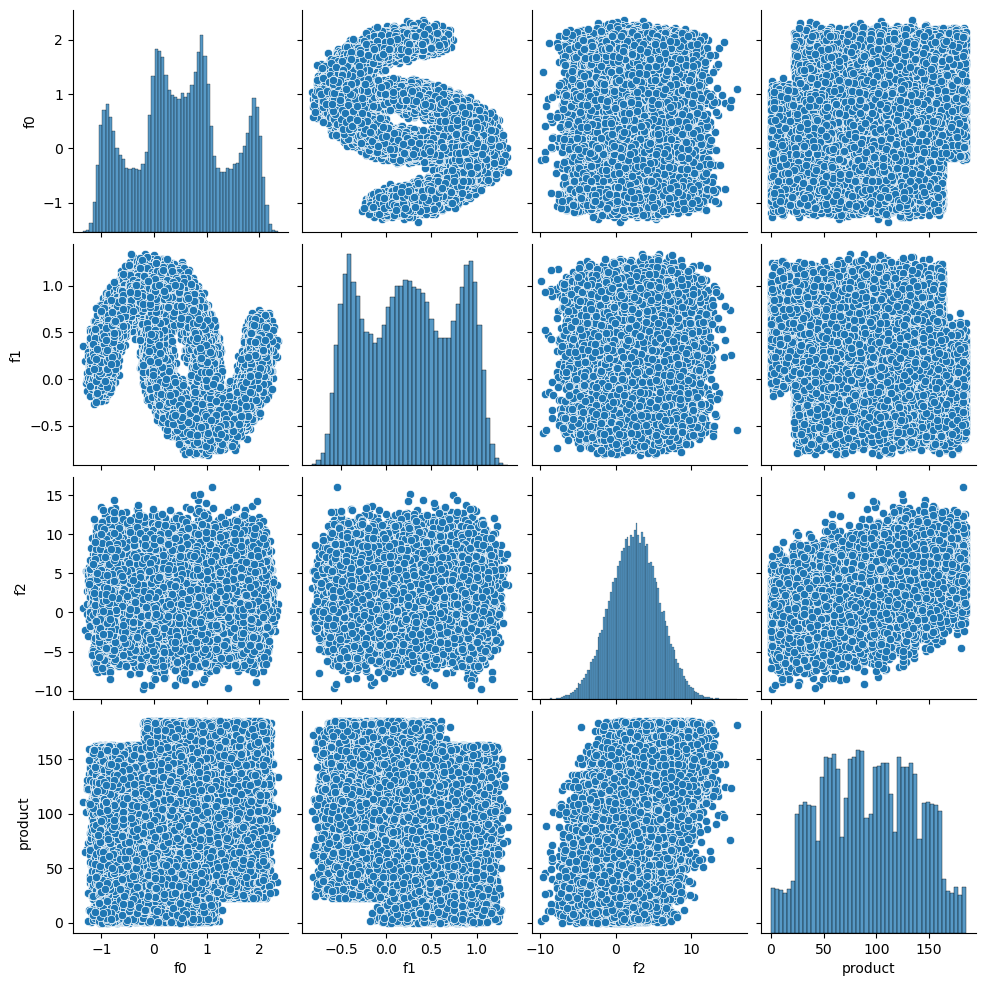

In [11]:
sns.pairplot(reg_1.sample(n=50000))
plt.show()

Мультиколллинеарности между признаками не наблюдаем!

C:\Users\alex\AppData\Local\Temp\ipykernel_1824\2155639816.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(reg_1.corr(), annot=True, cmap="Greens")


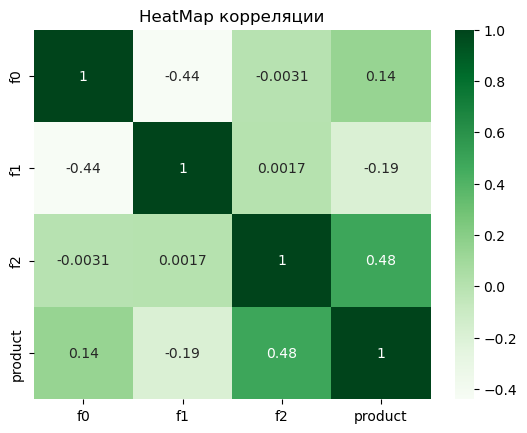

In [12]:
sns.heatmap(reg_1.corr(), annot=True, cmap="Greens")
plt.title('HeatMap корреляции')
plt.show()

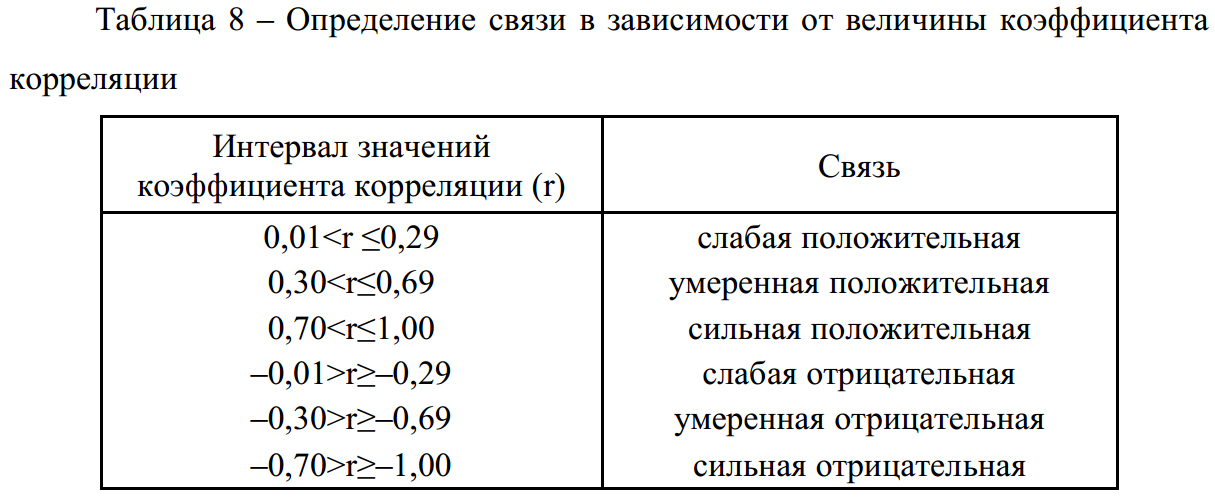

**Видим, что наибольшая корреляция 0.48 (умеренная-положительная) наблюдается между признаком f2 и таргетом. Между признаками наблюдается слабая коллинеарность. Следовательно, проблемы мультиколлинеарности нет.**

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />
        Корреляция - по определению является мерой <b>линейной</b> зависимости данных. 

In [13]:
nums = np.random.random(10000) *  np.pi
sins = np.sin(nums)

np.corrcoef(nums, sins)

array([[ 1.        , -0.03409547],
       [-0.03409547,  1.        ]])

<div class="alert alert-info">
<font size="4"></font>
    <font size="3", color = "black">
Нет никаких сомнений, что между числами и их синусами есть зависимость, но коэффициент корреляции равен -0.0033, что можно считать погрешностью. Потому что синус - периодическая функция, которая скачет вверх вниз, а линейная зависимость говорит о том, что, если растёт одно значени, то растёт другое. Этого в случае синуса нет, следовательно, коэффициент корреляции нулевой.<br>

Поэтому корректнее всего говорить, что между признаками <b>нет линейной зависимости</b>.

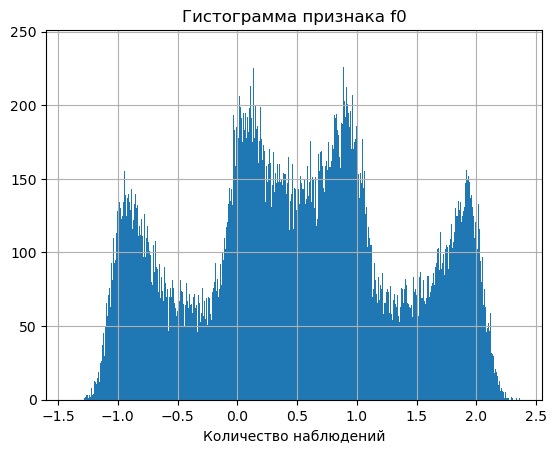

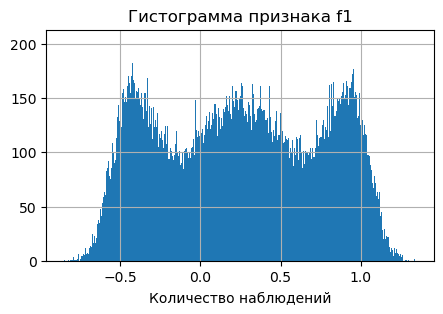

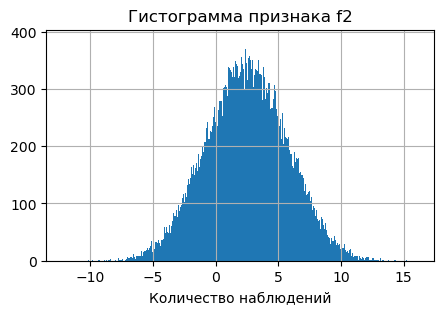

In [14]:
feature = ['f0', 'f1', 'f2']

for i in feature:
    reg_1[i].hist(bins=1000)
    plt.rcParams['figure.figsize'] = (5, 3)
    plt.xlabel('Значение')
    plt.xlabel('Количество наблюдений')
    plt.title(f'Гистограмма признака {i}')
    plt.show()

Видим, что в данных нет сильно-выделяющихся объектов.

Построим распределение таргетов отдельно:


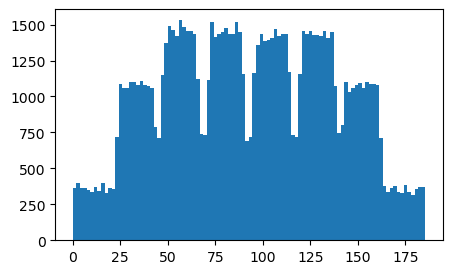

In [15]:

plt.hist(reg_1['product'], bins=100)
plt.show()

Таргет имеет распределение далекое от нормального.

## Регион 2


Посмотрим описательные статистики для 2 региона:

In [16]:
reg_2[['f0', 'f1', 'f2']].describe()

,f0,f1,f2
count,99996.000000,99996.000000,99996.000000
mean,1.141450,-4.796493,2.494551
std,8.965922,5.119900,1.703579
min,-31.609576,-26.358598,-0.018144
25%,-6.298525,-8.267985,1.000021
50%,1.153190,-4.813005,2.011479
75%,8.621015,-1.332704,3.999904
max,29.421755,18.734063,5.019721


Видим, что стандартное отклонение у величин небольшое, это говорит об отсутствии выбросов в данных. Чтобы в этом убедиться построим множественный scatterplot и построим на взаимосвязи в данных, а также их распределение.

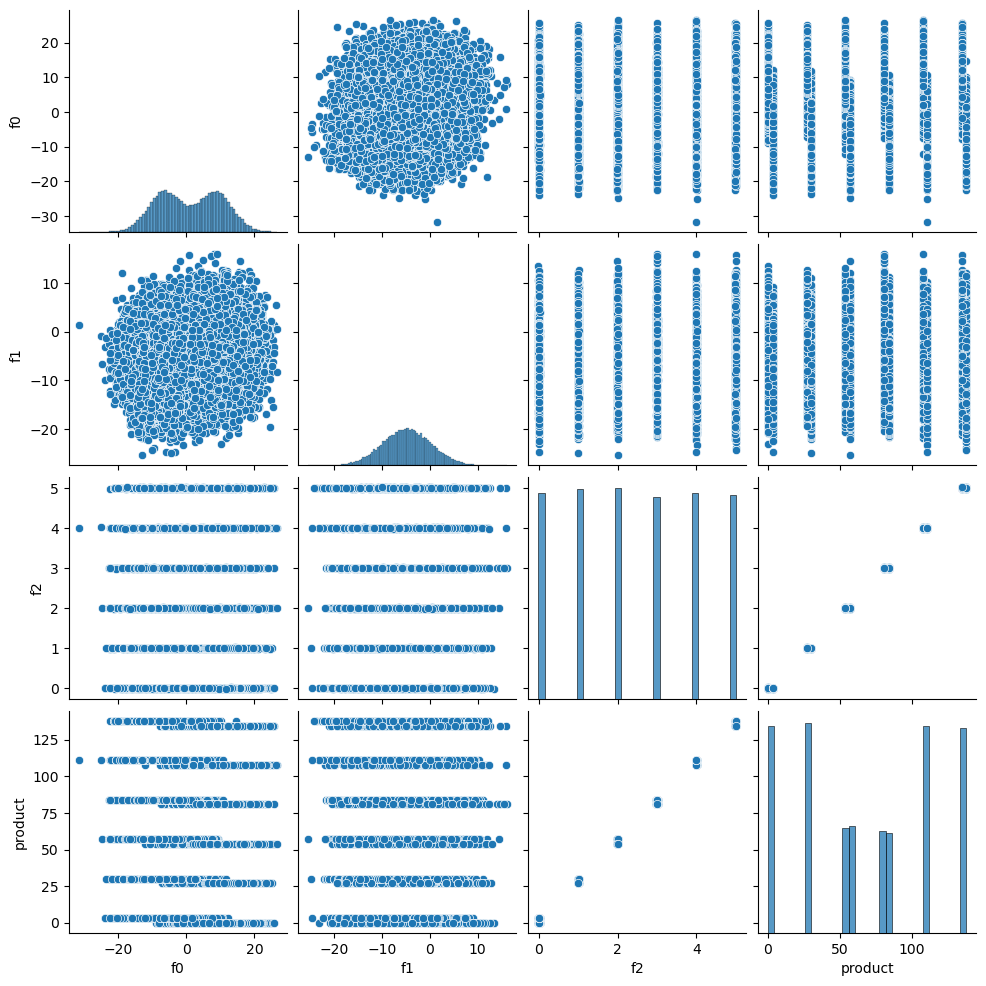

In [17]:
sns.pairplot(reg_2.sample(n=50000))
plt.show()

Видим, что признак f2 линейно-зависим от таргета! Это очень хорошо, хороший признак!) В остальном, в признаках мультиколлинеарности не наблюдаю.

C:\Users\alex\AppData\Local\Temp\ipykernel_1824\561512148.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(reg_2.corr(), annot=True, cmap="Greens")


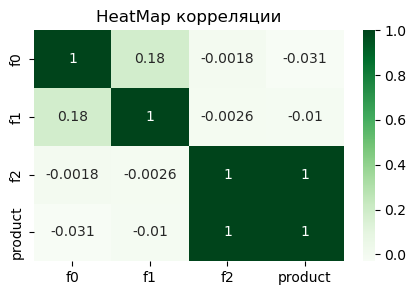

In [18]:
sns.heatmap(reg_2.corr(), annot=True, cmap="Greens")
plt.title('HeatMap корреляции')
plt.show()

**Видим, сильную линейную связь между признаком f2 и таргетом. Между признаками наблюдается слабая коллинеарность. Следовательно, проблемы мультиколлинеарности нет.**

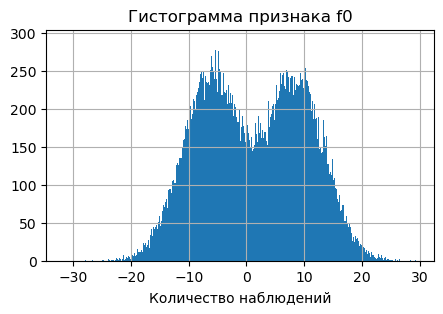

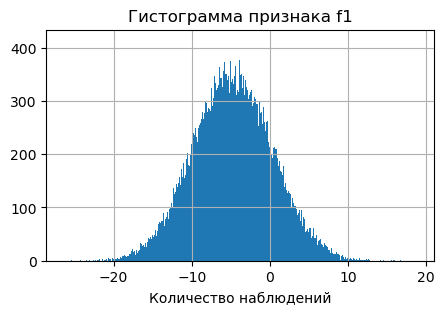

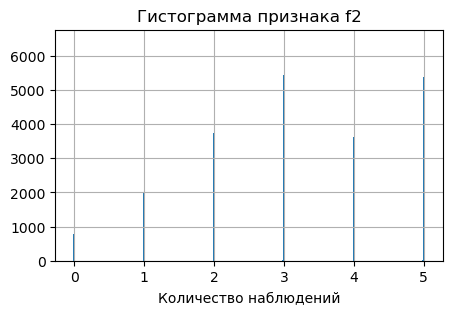

In [19]:
feature = ['f0', 'f1', 'f2']

for i in feature:
    reg_2[i].hist(bins=1000)
    plt.rcParams['figure.figsize'] = (5, 3)
    plt.xlabel('Значение')
    plt.xlabel('Количество наблюдений')
    plt.title(f'Гистограмма признака {i}')
    plt.show()

Видим, что в данных нет сильно-выделяющихся объектов.

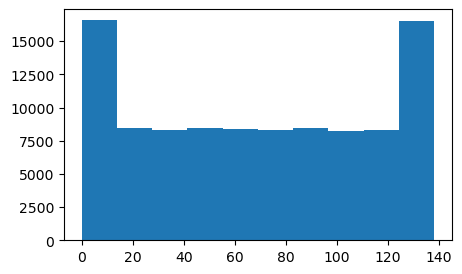

In [20]:
plt.hist(reg_2['product'], bins=10)
plt.show()

Таргет имеет распределение далекое от нормального.

## Регион 3


Посмотрим описательные статистики для 3 региона

In [21]:
reg_3[['f0', 'f1', 'f2']].describe()

,f0,f1,f2
count,99996.000000,99996.000000,99996.000000
mean,0.001995,-0.002034,2.495132
std,1.732054,1.730424,3.473453
min,-8.760004,-7.084020,-11.970335
25%,-1.162288,-1.174805,0.130359
50%,0.009411,-0.009433,2.484236
75%,1.158477,1.163760,4.858720
max,7.238262,7.844801,16.739402


Видим, что стандартное отклонение у величин небольшое, это говорит об отсутствии выбросов в данных. Чтобы в этом убедиться построим множественный scatterplot и построим на взаимосвязи в данных, а также их распределение.

Поскольку у нас 100к наблюдений, то я выберу подвыборку из 50к, чтобы снизить нагрузку на процессор. По закону ЦПТ распределение данной подвыборки будет близко к истинному распределению генеральной совокупности.

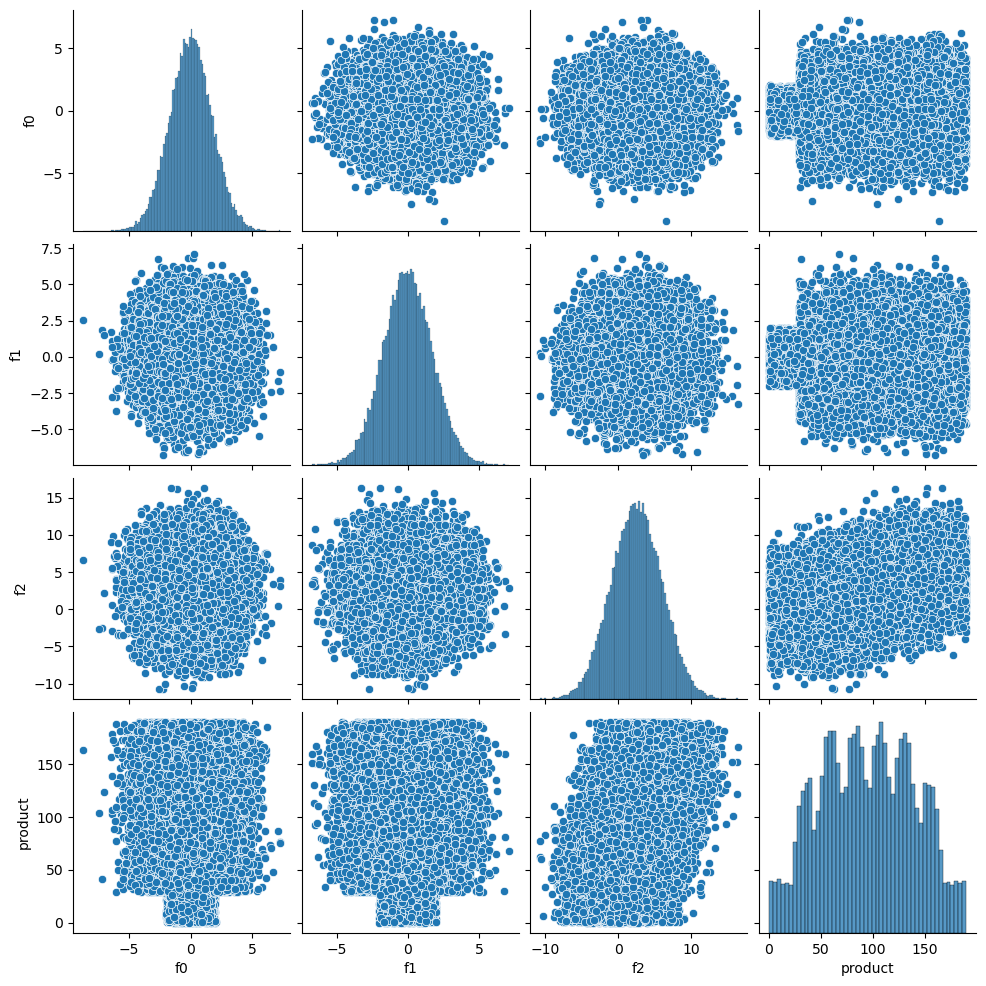

In [22]:
sns.pairplot(reg_3.sample(n=50000))
plt.show()

Мультиколллинеарности между признаками не наблюдаем!

C:\Users\alex\AppData\Local\Temp\ipykernel_1824\3595677360.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(reg_3.corr(), annot=True, cmap="Greens")


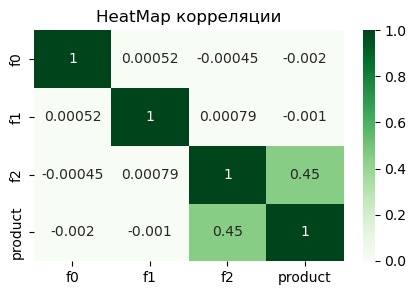

In [23]:
sns.heatmap(reg_3.corr(), annot=True, cmap="Greens")
plt.title('HeatMap корреляции')
plt.show()

**Видим, сильную линейную связь между признаком f2 и таргетом. Между признаками наблюдается слабая зависимость. Следовательно, проблемы мультиколлинеарности нет.**

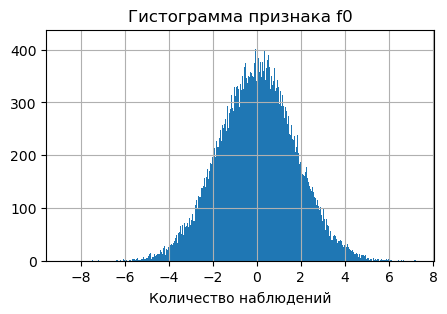

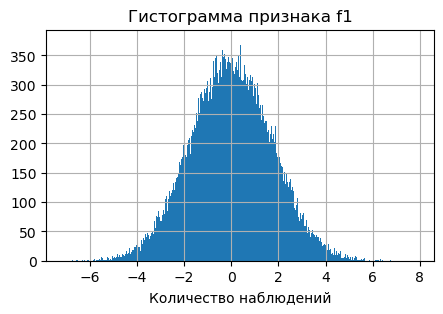

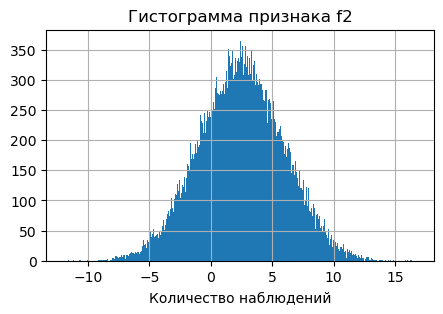

In [24]:
feature = ['f0', 'f1', 'f2']

for i in feature:
    reg_3[i].hist(bins=1000)
    plt.rcParams['figure.figsize'] = (5, 3)
    plt.xlabel('Значение')
    plt.xlabel('Количество наблюдений')
    plt.title(f'Гистограмма признака {i}')
    plt.show()

Видим, что в данных нет сильно-выделяющихся объектов.

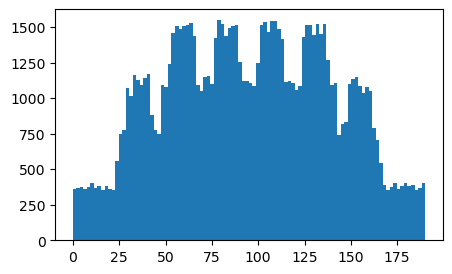

In [25]:
plt.hist(reg_3['product'], bins=100)
plt.show()

Таргет имеет распределение далекое от нормального.

# Пространство признаков для исследования

Фичу id для предсказания линейной регрессии не будем, она не влияет на таргет. Таким образом, признаковое пространство будет такое:

In [26]:
numeric_features = ['f0', 'f1', 'f2']

# Разбиваем данные

Разобьем данные на train и  val по каждому региону

In [27]:
train_reg_1, val_reg_1 = train_test_split(reg_1, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_STATE)
train_reg_2, val_reg_2 = train_test_split(reg_2, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_STATE)
train_reg_3, val_reg_3 = train_test_split(reg_3, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_STATE)

# Pipeline модели

Построим pipeline наших будущих моделей. Используем для линейной модели масштабирование данных(стандартизацию):

In [28]:
# масштабирую и заполняю числовые признаки
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

pipe = Pipeline(steps=[
                ('preprocessor_feature', preprocessor),
                ('model', LinearRegression( n_jobs=-1))])

In [29]:


set_config(display='diagram')   

pipe

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', LinearRegression(n_jobs=-1))])

# Baseline

В качестве baseline использую **dummyRegressor**, в качестве константы использую среднее значение

In [30]:
# масштабирую и заполняю числовые признаки
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

pipe_dummy = Pipeline(steps=[
                ('preprocessor_feature', preprocessor),
                ('model', DummyRegressor(strategy='mean'))])

In [31]:
pipe_dummy

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', DummyRegressor())])

In [32]:
pipe_dummy.fit(train_reg_1[numeric_features], train_reg_1['product'])

Pipeline(steps=[('preprocessor_feature',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', DummyRegressor())])

In [33]:
def baseline(train, val):
    pipe_dummy.fit(train[numeric_features], train['product'])
    rmse = np.sqrt(mean_squared_error(val['product'], pipe_dummy.predict(val[numeric_features]) ))
    return rmse
    
    

In [34]:
datasets = [[train_reg_1, val_reg_1],
           [train_reg_2, val_reg_2],
           [train_reg_3, val_reg_3]]

In [35]:
for i, j in zip(datasets, [1, 2, 3]):
    print(f'RMSE на Baseline в {j} регионе: {baseline(i[0], i[1])}')

RMSE на Baseline в 1 регионе: 44.43254074687915
RMSE на Baseline в 2 регионе: 45.835774588965144
RMSE на Baseline в 3 регионе: 44.77013273573705


Теперь наша задача на моделях пробить baseline, чем ниже будет RMSE, тем лучше

## Обучение и проверка моделей

Напишем функцию, вычисляющую предсказание модели, RMSE и среднее предсказанных значений

Предсказанные ответы сохраним в валидационную выборку, чтобы далее было проще работать.

In [36]:
def model_calculation(train, val):
    pipe.fit(train[numeric_features], train['product'])
    pred = pipe.predict(val[numeric_features])
    rmse = np.sqrt(mean_squared_error(val['product'], pred))
    pred_mean = pred.mean()
    val['predict'] = pred
    print(f'Среднее предсказания модели: {pred_mean}')
    print(f'Истинное среднее значение: {val["product"].mean()}')
    print(f'RMSE модели: {rmse}')
    

**1 регион**

In [37]:
model_calculation(train_reg_1, val_reg_1)

Среднее предсказания модели: 92.36532054199266
Истинное среднее значение: 92.22418381862296
RMSE модели: 37.80659070512707


В 1 регионе видим высокое значение метрики RMSE, модель сильно ошибается.

**2 регион**

In [38]:
model_calculation(train_reg_2, val_reg_2)

Среднее предсказания модели: 69.04412081335099
Истинное среднее значение: 69.04793826913262
RMSE модели: 0.8907546230101846


Во 2 регионе видим низкое значение метрики RMSE, модель хорошо прогнозирует.

**3 регион**

In [39]:
model_calculation(train_reg_3, val_reg_3)

Среднее предсказания модели: 94.91790172049365
Истинное среднее значение: 94.82484841065816
RMSE модели: 40.13849714263183


В 3 регионе видим высокое значение метрики RMSE, модель сильно ошибается.

## Подготовка к расчёту прибыли

**Бюджет** на разработку скважин в регионе - **10 миллиардов.**

При нынешних ценах **один баррель сырья приносит 450 рублей** дохода. Доход с каждой единицы продукта составляет **450 тыс. рублей, поскольку объём указан в тысячах баррелей.**

Следовательно, чтобы не уйти в убыток, выкачка должна достигать:
    

In [40]:
V_profit = (BUDGET / (BARREL_PRICE))
print(V_profit)

22222.222222222223


Поскольку у нас будут выбраны 200 лучших скважин, то разделим число выше на 200, чтобы узнать **сколько должна добывать минимально 1 скважина, чтобы не уйти в убыток.**

In [41]:
min_V_profit = V_profit / TOP_HOLE
min_V_profit

111.11111111111111

То есть, **чтобы окупиться**, учитывая бюджет на разработку, наша скважина должна **добывать более 111.111 тысяч** баррелей нефти!

Посмотрим средние значения запасов по региону:

In [42]:
reg_1['product'].mean()

92.49948184460142

In [43]:
reg_2['product'].mean()

68.82523184270339

In [44]:
reg_3['product'].mean()

95.00042479767433

Видим, что для преодоления потолка в 111.11 тысяч барелелей ближе всего 1 и 3 регионы, а 2 регион имеет меньшее среднее. Это говорит о том, что в регионе есть много малодобывающих скважин, а в остальных регионах скважины имеют бОльшую добычу.

## Расчёт прибыли и рисков 

In [45]:
def income_top_200(val):
    val = val.reset_index()
    top = val['predict']\
            .sort_values(ascending=False)\
            .head(TOP_HOLE).index
    
    income = val['product'].loc[top].sum()*BARREL_PRICE - BUDGET
            
    return income

In [46]:
# получение таргетов для лучших 200 предсказаний, на примере региона 1
val_reg_1.sort_values('product', ascending=False)['predict'][:200]

8826     123.541014
94175    132.381186
1925     124.645976
66714     84.899908
98529    106.628523
            ...    
48629    150.470429
95563    114.140352
30048    117.740256
80701    128.963139
98557    125.036470
Name: predict, Length: 200, dtype: float64

**1 регион:**

In [47]:
print(f'Прогнозируемая прибыль с 200 лучших скважин: {round(income_top_200(val_reg_1)/ 10**9, 3)} млрд.р.')


Прогнозируемая прибыль с 200 лучших скважин: 3.594 млрд.р.


**2 регион:**

In [48]:
print(f'Прогнозируемая прибыль с 200 лучших скважин: {round(income_top_200(val_reg_2)/ 10**9, 3)} млрд.р.')


Прогнозируемая прибыль с 200 лучших скважин: 2.415 млрд.р.


**3 регион:**

In [49]:
print(f'Прогнозируемая прибыль с 200 лучших скважин: {round(income_top_200(val_reg_3)/ 10**9, 3)} млрд.р.')


Прогнозируемая прибыль с 200 лучших скважин: 2.428 млрд.р.


## Бутстреп

Напишем функцию, выполняющую бутстреп, расчитывающая доверительный интервал, среднюю прибыль и риск убытка. А также, строющую распрделение дохода. Также проверим тест Шапиро для определения нормальности распрделения.

In [50]:
state = np.random.RandomState(42)

In [51]:
def profit_bootstrap(val):
    values = []
    for i in range(1000):
        subsample_top = val[['product', 'predict']].sample(n=HOLE, replace=True, random_state=state)
            
        values.append(income_top_200(subsample_top))
        
    values = pd.Series(values)
    confidence_interval = values.quantile(0.025), values.quantile(0.975)
    income = values.mean()
    loss = values[values <= 0].mean()
    print(f'95% Доверительный интервал прибыли Bootstrap: от {round(confidence_interval[0]/ 10**9, 3)} до {round(confidence_interval[1]/ 10**9, 3)} млрд.р.')
    print(f'Средняя прибыль: {round(income/ 10**9, 3)} млрд.р.')
    print(f'Вероятность убытка: {(values<=0).mean()}')
    if ((values<=0).mean()) < (2.5/100):
        print("Порог вероятности меньше 2.5% ПРОЙДЕН")
    else: 
        print("Порог вероятности меньше 2.5% НЕ ПРОЙДЕН")
    shap = shapiro(values)
    print(f'Шапиро с p-value 0.05 пройден: {shap.pvalue < 0.05}')
        
    sns.histplot(values, kde=True)
    y = np.linspace(0, 120, 1000)
    plt.plot([values.mean()]*1000, y, label='mean', linestyle='--', linewidth=2, color='r')
    plt.plot([values.median()]*1000, y, label='median', linestyle='-.', linewidth=2, color='g')
    plt.xlabel('Прибыль в млрд.')
    plt.ylabel('Количество наблюдений')
    plt.legend()
    plt.rcParams['figure.figsize'] = (5, 5)
    plt.show()

**1 регион:**

95% Доверительный интервал прибыли Bootstrap: от -0.098 до 0.929 млрд.р.
Средняя прибыль: 0.393 млрд.р.
Вероятность убытка: 0.057
Порог вероятности меньше 2.5% НЕ ПРОЙДЕН
Шапиро с p-value 0.05 пройден: False


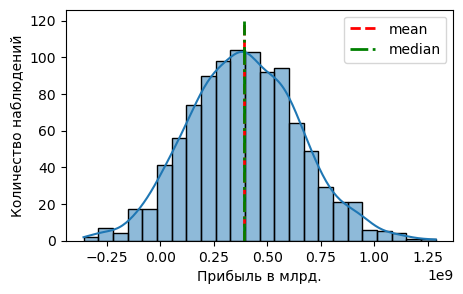

In [52]:
# 1 регион
profit_bootstrap(val_reg_1)

**2 регион:**

95% Доверительный интервал прибыли Bootstrap: от 0.054 до 0.859 млрд.р.
Средняя прибыль: 0.454 млрд.р.
Вероятность убытка: 0.012
Порог вероятности меньше 2.5% ПРОЙДЕН
Шапиро с p-value 0.05 пройден: False


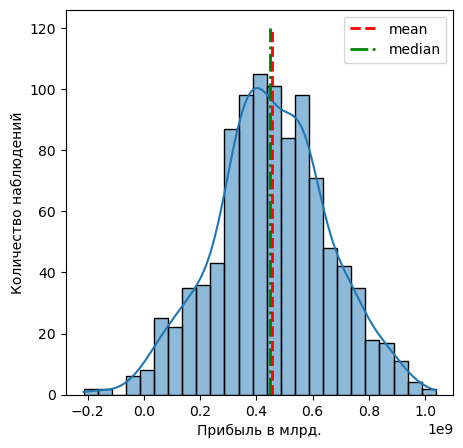

In [53]:
# 2 регион
profit_bootstrap(val_reg_2)

Распределение дохода имеет нормальное распрделение. Тест Шапиро  пройден

**3 регион:**

95% Доверительный интервал прибыли Bootstrap: от -0.149 до 0.84 млрд.р.
Средняя прибыль: 0.361 млрд.р.
Вероятность убытка: 0.091
Порог вероятности меньше 2.5% НЕ ПРОЙДЕН
Шапиро с p-value 0.05 пройден: False


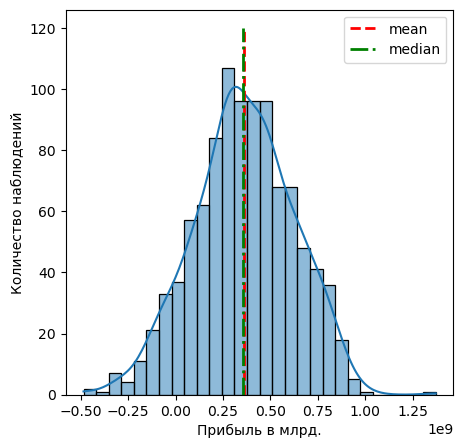

In [54]:
# 3 регион
profit_bootstrap(val_reg_3)

Распределение дохода имеет НЕ нормальное распрделение. Тест Шапиро не пройден

# Дополнительная экспериментальная часть (синтетические данные)

Предположим, что мы проводили A/B тестирование, в котором в группе A были 25к наблюдений со старым способом детектирования запасов скважины, а в группе B мы использовали новые технологии более точной оценки скважины. Необходимо понять существует ли статистическая значимость в разнице оценки запасов между этими двумя группами. 


Также **инвесторов интересуют** следующие показатели:
* Валовая прибыль компании
* Валовая маржинальность
* Операционная прибыль
* Операционная маржинальность
* Чистая прибыль по итогам года
* Метрика ROI



Создадим данные, в качестве контрольной группы используем изначальные запасы в скважине, в качестве второй группы возьмем предсказания модели на ней и умножим на некоторый коэффициент.

In [55]:
test = pd.DataFrame()

In [56]:
test['product_A'] = val_reg_1['product']

In [57]:
test['product_B'] = val_reg_1['predict']*1.15

In [58]:
test

,product_A,product_B
33971,46.415405,98.696729
22859,77.332426,137.601863
19453,149.721614,134.583942
9736,93.439209,90.707132
7133,127.207120,111.431113
...,...,...
60955,59.215036,79.526383
66182,135.988566,110.405163
45155,134.554103,132.810821
14676,162.113891,94.867890


Первое, что хочу **проверить - равенство средних в этих выборках.**
* Гипотеза H0: между выборками нет существенных различий
* Гипотеза H1: между выборками существуют различия
Выберем уровень alpha = 0.05 - вероятность ошибки 1 рода


Для равенства средних используем t-test Стьюдента для независимых выборок. Тест односторонний, поскольку мы сравниваем средние выборок

In [59]:
# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

alpha = 0.05 / 2

print("Cреднее до:", test['product_A'].mean())
print("Cреднее после:", test['product_B'].mean())

pvalue = ttest_ind(test['product_A'], test['product_B']).pvalue

print('p-значение: ', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего средняя добыча теперь прогнозируется лучше")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


Cреднее до: 92.22418381862296
Cреднее после: 106.22011862329154
p-значение:  0.0
Отвергаем нулевую гипотезу: скорее всего средняя добыча теперь прогнозируется лучше


Теперь построим 95% доверительный интервал для среднего через t.interval:

In [60]:
print("Cреднее до внедрения новых технологий:", test['product_A'].mean())
print("Cреднее после внедрения новых технологий:", test['product_B'].mean())


confidence_interval_A = t.interval(0.95, len(test['product_A'])-1, test['product_A'].mean(), test['product_A'].sem())
confidence_interval_B = t.interval(0.95, len(test['product_B'])-1, test['product_B'].mean(), test['product_B'].sem())

print("95%-ый доверительный интервал до внедрения новых технологий:", np.round(confidence_interval_A, 2))
print("95%-ый доверительный интервал после внедрения новых технологий:", np.round(confidence_interval_B, 2))

Cреднее до внедрения новых технологий: 92.22418381862296
Cреднее после внедрения новых технологий: 106.22011862329154
95%-ый доверительный интервал до внедрения новых технологий: [91.67 92.78]
95%-ый доверительный интервал после внедрения новых технологий: [105.89 106.55]


Теперь сам A/B тест:

Бутстрап для A\B теста для определения есть ли разница в прогнозировании добычи новыми технологиями:

Считаем фактическую разницу средних значений добычи в группах. Затем формулируем и проверяем гипотезы. Нулевая предполагает равенство средних добычи в обеих группах. Альтернативная — в экспериментальной группе средняя добыча выше. Найдём p-value.

Будем брать по 500 объектов, 1000 итераций:

In [61]:
alpha = 0.05
state = np.random.RandomState()

AB_difference = test['product_B'].mean() - test['product_A'].mean()
print("Разность средних объемов добычи:", AB_difference)

bootstrap_samples = 1000 # 1000 итераций
count = 0

for i in range(bootstrap_samples):
    # объединяем выборки
    united_samples = pd.concat([test['product_B'], test['product_A']])
    
    # создаем подвыборку
    subsample = united_samples.sample(n=500, replace=True, random_state=state)
    
    # разбиваем выборку пополам
    subsample_A = subsample[:len(test['product_B'])]
    subsample_B = subsample[len(test['product_B']):]
    
    # считаем между ними разницу средних
    bootstrap_difference = subsample_B.mean() - subsample_A.mean()
    
    # если разница больше фактической, увеличиваем счётчик
    if bootstrap_difference >= AB_difference:
        count += 1
        
# p-value равно доле превышений значений
pvalue = 1. * count / bootstrap_samples
print('p-value =', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего средняя добыча теперь прогнозируется лучше")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Разность средних объемов добычи: 13.995934804668579
p-value = 0.0
Отвергаем нулевую гипотезу: скорее всего средняя добыча теперь прогнозируется лучше


Посчитаем средний оборот компании, посчитаем его на улучшенном продукте B, из которого для исследования мы берем 200 лучших скважин:

Теперь подсчет метрик, интересующих инвесторов. Предположим, что за год мы заплатили рабочим 30 млн, расходы на аренду оборудование 10 млн, расходы на свет 15 млн., налоги 4%, бюджет на исследование скважин 10 млрд. Обслуживание долга 30 млн.

То есть, себестоимость 10 млрд + затраты на свет 15 млн. 
Операционные расходы = расходы на аренду оборудования + зарплаты рабочим = 40 млн.

Инвестиции = 3 млрд рублей.

**Оборот компании для 200 скважин:**

In [62]:
turn = test['product_B'].sort_values(ascending=False).head(200).sum() * 450000
turn

16072540830.378294

**Валовая прибыль компании = оборот - себестоимость:**

In [63]:
val_income = turn - 10*10**9 + 15*10**6
val_income

6087540830.378294

**Валовая маржинальность = (Валовая прибыль / оборот)*100%:**

In [64]:
val_margya = (val_income / turn)*100
val_margya

37.875410581458226

**Операционная прибыль = валовая прибыль - операционные расходы**.

Операционные расходы = расходы на аренду оборудования + зарплаты рабочим = 40 млн

In [65]:
operation_income = val_income - 40*10**6
operation_income

6047540830.378294

**Операционная маржинальность = (операционная прибыль \ выручка)*100%**

In [66]:
operation_margya = (operation_income / turn) *100
operation_margya

37.6265389162863

**Чистая прибыль = (Операционная прибыль - Налоги - Обслуживание долга)**. У на налоги 4%, обслуживание долга 30 млн.

In [67]:
clean_income = operation_income - turn*0.04 - 30*10**6
clean_income

5374639197.163162

**Посчитаем ROI = (Итоговая прибыль - Инвестиции)/ Инвестиции:** Инвестиции составили 3 млрд рублей

In [68]:
ROI = (clean_income - 3*10**9)/(3*10**9)
ROI

0.7915463990543874

То есть, 78% вложений инвесторов уже окупились.

In [69]:
# Итоговый отчет по метрикам, интересующих инвесторов:
print('По результатам A\B тестирования группа B показала прирост обнаружения добычи нефти. Однозначно стоит внедрять новые технологии!')
print('**********************************************')
print(f'Оборот компании составил: {round(turn / 10**9, 3)} млрд. рублей')
print(f'Валовая прибыль компании составила: {round(val_income / 10**9, 3)} млрд. рублей')
print(f'Валовая маржинальность компании составила: {round(val_margya, 2)}%')
print(f'Операционная прибыль компании составила: {round(operation_income / 10**9, 3)} млрд. рублей')
print(f'Операционная маржинальность компании составила: {round(operation_margya, 2)}%')
print(f'Чистая прибыль компании составила: {round(clean_income / 10**9, 3)} млрд. рублей')
print(f'ROI составила: {round(ROI, 3)*100}%. Столько вложений инвесторов уже окупилось.')

По результатам A\B тестирования группа B показала прирост обнаружения добычи нефти. Однозначно стоит внедрять новые технологии!
**********************************************
Оборот компании составил: 16.073 млрд. рублей
Валовая прибыль компании составила: 6.088 млрд. рублей
Валовая маржинальность компании составила: 37.88%
Операционная прибыль компании составила: 6.048 млрд. рублей
Операционная маржинальность компании составила: 37.63%
Чистая прибыль компании составила: 5.375 млрд. рублей
ROI составила: 79.2%. Столько вложений инвесторов уже окупилось.


# Вывод

Все модели пробили минимальный baseline RMSE 44-45. Наименьший RMSE был у 2 региона, поскольку признак f2 был линейно-зависим от таргета.

Таким образом, учитывая что после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%, а также выбрать из них регион с наибольшей средней прибылью - я советую к разработке 2 регион. 


Поскольку его 95% доверительный интервал показывает, что прибыль находится в интервале (0.046, 0.867)млрд.руб.

Такжже он имеет наибольшую среднюю прибыль - 0.46 млрд.руб во втором регионе, против  0.398 млрд.р. и 0.337 млрд.р. в 1 и 3 регионах соответственно.

Второй регион единственный прошел проверку, заключающуюся в риске убытков менее 2.5%. 

Тест Шапиро на нормальность распределения дохода проходит только 3 регион.
